## SVR on second iteration and GLM Negative Binomial Regression
#### allows the model to be trained on the disease count the week before

some code taken from blog post:  http://blog.drivendata.org/2016/12/23/dengue-benchmark/

What I've done here is train a model (SVC) on the data to predict the total dengue cases in the test set.  I noticed the total cases predicted was low, so added in the average of the total cases per week of year throughout the entire training set to the predictions (ex. in week 52, in San Jose, the avg number of cases in the training set is 24). 

In [35]:
#standard imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import time as time

from warnings import filterwarnings
filterwarnings('ignore')

In [36]:
#load dataset
df=pd.read_csv('train_edited.csv') #training set with preprocessing already implemented
#labels = pd.read_csv('dengue_labels_train.csv')
test = pd.read_csv('test_preds_added.csv')# this is the testing data with one iteration of predictions
#fill NaNs - ffill bc it is a timeseries
df.fillna(method='ffill', inplace=True)
test.fillna(method='ffill', inplace=True)
#to datetime
df['week_start_date']=pd.to_datetime(df['week_start_date'])
test['week_start_date']=pd.to_datetime(test['week_start_date'])
#extract month to new column
df['month']=df.week_start_date.dt.month
test['month']=test.week_start_date.dt.month
#merge labels
#df=pd.merge(df, labels, on=['city', 'year', 'weekofyear'])

In [37]:
df.rename(columns={'total_cases_x': 'total_cases'}, inplace=True)

In [38]:
# separate san juan and iquitos
sj = df[df['city']=='sj']
iq = df[df['city']=='iq']

sj_test=test[test['city']=='sj']
iq_test=test[test['city']=='iq']

### preprocessing - add columns for previous counts of dengue

In [39]:
#value previous week
#train
sj['cases_prev_wk'] = sj['total_cases'].shift(1)
iq['cases_prev_wk'] = iq['total_cases'].shift(1)

#test
sj_test['cases_prev_wk'] = sj_test['total_cases'].shift(1)
iq_test['cases_prev_wk'] = iq_test['total_cases'].shift(1)

#need to make sure no NaNs added when creating moving avg or getting previous week values
sj.fillna(method='bfill', inplace=True)
iq.fillna(method='bfill', inplace=True)

sj_test.fillna(method='bfill', inplace=True)
sj_test.fillna(method='bfill', inplace=True)

In [40]:
#these features performed better
features2=[
'total_cases_avg',                                      
'rolling_avg_reanalysis_specific_humidity_g_per_kg',    
'rolling_avg_station_avg_temp_c',                       
'rolling_avg_reanalysis_dew_point_temp_k',              
'rolling_avg_station_min_temp_c',                       
'rolling_avg_station_max_temp_c',                       
'rolling_avg_reanalysis_min_air_temp_k',                
'rolling_avg_reanalysis_max_air_temp_k',                
'rolling_avg_reanalysis_air_temp_k',                    
'rolling_avg_reanalysis_avg_temp_k',            
'reanalysis_specific_humidity_g_per_kg',               
'reanalysis_dew_point_temp_k',                          
'reanalysis_min_air_temp_k',                           
'station_min_temp_c',
'cases_prev_wk'
    ]      

#TRAIN
X_sj= sj[features2]
Y_sj = sj['total_cases']

X_iq= iq[features2]
Y_iq = iq['total_cases']

#TEST
X_sj_t= sj_test[features2]

X_iq_t= iq_test[features2]


#need to make sure no NaNs added when creating moving avg or getting previous week values
X_sj.fillna(method='bfill', inplace=True)
X_iq.fillna(method='bfill', inplace=True)

X_sj_t.fillna(method='bfill', inplace=True)
X_iq_t.fillna(method='bfill', inplace=True)

## create model for second iteration
this iteration uses the dengue counts from the previous two weeks as a feature column
note that the dengue counts on the previous weeks for the testing set were predicted in first iteration

In [41]:
##SAN JUAN
train_size = 100
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})

t0 = time.time()
svr.fit(X_sj,Y_sj)
svr_fit = time.time() - t0
print("SVR complexity and bandwidth selected and model fitted in %.3f s"
      % svr_fit)

SVR complexity and bandwidth selected and model fitted in 9.101 s


In [42]:
model_sj=svr.best_estimator_
model_sj

SVR(C=100.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [43]:
##IQUITOS
train_size = 100
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})

t0 = time.time()
svr.fit(X_iq,Y_iq)
svr_fit = time.time() - t0
print("SVR complexity and bandwidth selected and model fitted in %.3f s"
      % svr_fit)

SVR complexity and bandwidth selected and model fitted in 3.917 s


In [44]:
model_iq=svr.best_estimator_
model_iq

SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [45]:
#further divide the training set to create a lineplot
sj_train_subtrain = sj.head(800)
sj_train_subtest = sj.tail(sj.shape[0] - 800)

iq_train_subtrain = iq.head(400)
iq_train_subtest = iq.tail(iq.shape[0] - 400)

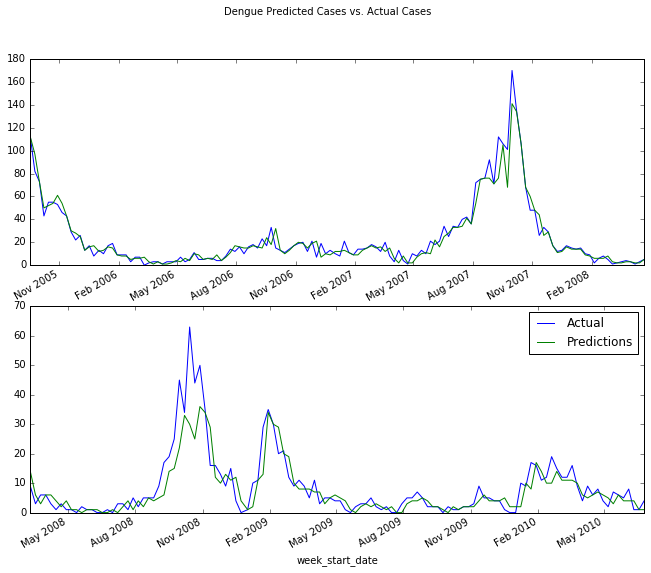

In [46]:
#create preds
preds_sj= model_sj.predict(sj_train_subtest[features2]).astype(int)
preds_iq=model_iq.predict(iq_train_subtest[features2]).astype(int)
#add to the dataframes
sj_train_subtest['fitted'] = preds_sj
iq_train_subtest['fitted'] = preds_iq
### reset axis
sj_train_subtest.index = sj_train_subtest['week_start_date']
iq_train_subtest.index = iq_train_subtest['week_start_date']
## make plot
figs, axes = plt.subplots(nrows=2, ncols=1, figsize=(11, 9))
sj_train_subtest.total_cases.plot(ax=axes[0], label="Actual")
sj_train_subtest.fitted.plot(ax=axes[0], label="Predictions")

iq_train_subtest.total_cases.plot(ax=axes[1], label="Actual")
iq_train_subtest.fitted.plot(ax=axes[1], label="Predictions")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()

In [13]:
## FIT THE MODELS
model_sj.fit(X_sj,Y_sj)
model_iq.fit(X_iq,Y_iq)

SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [14]:
#predict for each city using test set
sj_predictions = model_sj.predict(X_sj_t).astype(int)
iq_predictions = model_iq.predict(X_iq_t).astype(int)

In [16]:
#take a look at predictions
iq_predictions

array([ 4,  2,  4,  3,  3,  3,  3,  3,  2,  3,  2,  5,  3,  6,  7, 12,  8,
       11,  7, 11, 11, 13,  8,  8, 18, 14,  6,  5, 12, 14, 11, 28, 24, 15,
       10, 11, 12,  8,  7,  7,  7,  6,  6,  5,  5,  5,  4,  3,  4,  4,  3,
        3,  4,  2,  3,  2,  2,  4,  4,  4,  3,  3,  3,  6,  6,  6,  8, 10,
        7, 15,  8,  8, 11, 10,  7, 10, 17, 20,  7,  6, 13, 19, 13, 16, 15,
       17, 11, 10, 11,  6,  5,  5,  5,  5,  6,  5,  5,  6,  4,  3,  4,  4,
        5,  4,  4,  2,  3,  2,  5,  2,  3,  3,  3,  4,  4,  6,  7,  9,  8,
       11,  9,  8,  9,  8, 13, 10, 10,  9, 22, 20, 11, 12, 13, 15, 30, 23,
       10, 16, 14,  8,  7,  8,  7,  7,  6,  5,  5,  7,  4,  5,  4,  4,  4,
        3,  3,  4])

Just from looking at the predicted values, we know this submission won't be perfect.  The predicted values are not as uniform and the counts are not as low as the benchmark, but the estimated values (estimated by inputting the mean cases at that week of the year and the predicted values from the first pass of the model) do not capture the variability, time dependence, and disease outbreak in the real(training) data.

In [17]:
#read in the driven data submission example and add the predictions
submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])

submission.to_csv("submissions/svr_predictions5.csv")

### This submission had a MAE of 26.3317

## another try with negative binomial regression

Upon research this model did quite well: http://blog.drivendata.org/2016/12/23/dengue-benchmark/

The article has an awesome explaination too!

Our target variable, total_cases is a non-negative integer, which means we're looking to make some count predictions. Standard regression techniques for this type of prediction include

- Poisson regression
- Negative binomial regression

Poisson regression fits according to the assumption that the mean and variance of the population distributiona are equal. When they aren't, specifically when the variance is much larger than the mean, the negative binomial approach is better. The negative binomial regression simply lifts the assumption that the population mean and variance are equal, allowing for a larger class of possible models. 

In [18]:
#these features performed better
features2=[
'total_cases_avg',                                      
'rolling_avg_reanalysis_specific_humidity_g_per_kg',    
'rolling_avg_station_avg_temp_c',                       
'rolling_avg_reanalysis_dew_point_temp_k',              
'rolling_avg_station_min_temp_c',                       
'rolling_avg_station_max_temp_c',                       
'rolling_avg_reanalysis_min_air_temp_k',                
'rolling_avg_reanalysis_max_air_temp_k',                
'rolling_avg_reanalysis_air_temp_k',                    
'rolling_avg_reanalysis_avg_temp_k',            
'reanalysis_specific_humidity_g_per_kg',               
'reanalysis_dew_point_temp_k',                          
'reanalysis_min_air_temp_k',                           
'station_min_temp_c',
'cases_prev_wk',
'total_cases'
    ]      

#TRAIN
X_sj= sj[features2]
Y_sj = sj['total_cases']

X_iq= iq[features2]
Y_iq = iq['total_cases']

#TEST
X_sj_t= sj_test[features2]

X_iq_t= iq_test[features2]


#need to make sure no NaNs
X_sj.fillna(method='bfill', inplace=True)
X_iq.fillna(method='bfill', inplace=True)

X_sj_t.fillna(method='bfill', inplace=True)
X_iq_t.fillna(method='bfill', inplace=True)

In [19]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools import eval_measures

def get_best_model(train, test):
    # Step 1: specify the form of the model
    
  

                    
    model_formula = "total_cases ~ 1 + " \
                    "rolling_avg_reanalysis_specific_humidity_g_per_kg + " \
                    "rolling_avg_reanalysis_dew_point_temp_k + " \
                    "rolling_avg_station_min_temp_c + " \
                    "rolling_avg_station_avg_temp_c + " \
                    "station_min_temp_c + "\
                    "reanalysis_dew_point_temp_k +" \
                    "cases_prev_wk"
                   
    
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model

In [20]:
sj_best_model = get_best_model(X_sj,X_sj_t)
iq_best_model = get_best_model(X_iq,X_iq_t)

best alpha =  0.0001
best score =  13.0138608027
best alpha =  1e-08
best score =  3.09185774472


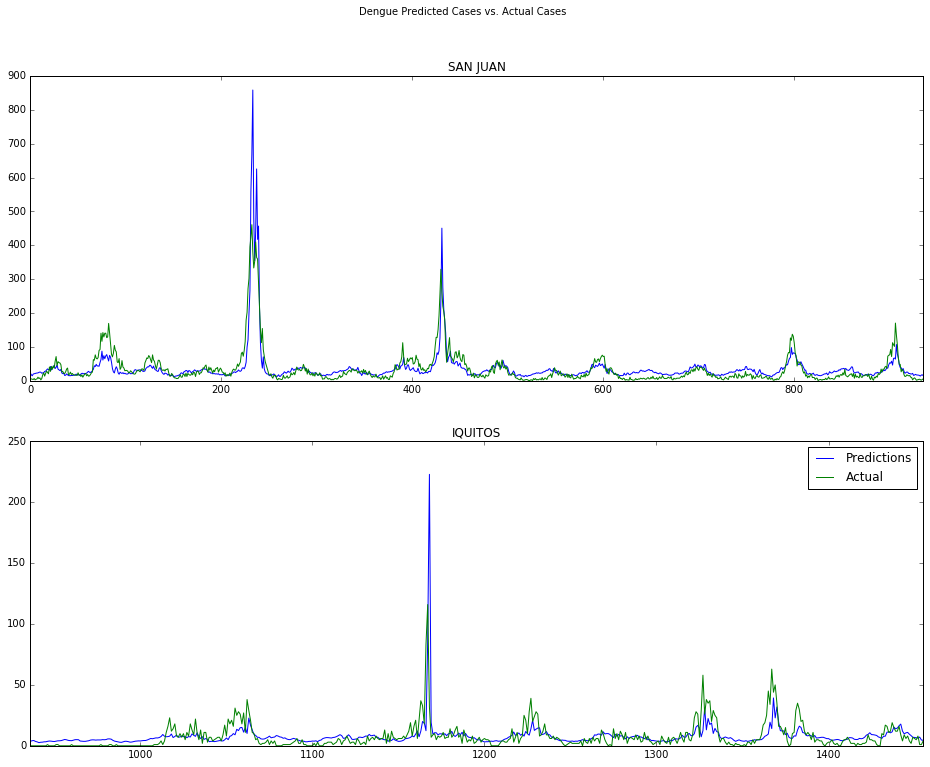

In [30]:
figs, axes = plt.subplots(nrows=2, ncols=1,figsize=(16, 12))

# plot sj
sj['fitted'] = sj_best_model.predict(X_sj)
sj.fitted.plot(ax=axes[0], label="Predictions")
sj.total_cases.plot(ax=axes[0], label="Actual", title="SAN JUAN")

# plot iq
iq['fitted'] = iq_best_model.predict(X_iq)
iq.fitted.plot(ax=axes[1], label="Predictions")
iq.total_cases.plot(ax=axes[1], label="Actual", title="IQUITOS")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()

This model is a big improvement.  Adding in the dengue counts from the previous week as a feature really increased the performance. This model would likely be able to predict a week or two in advance.  Indeed, I've read some papers where the next week's predicted cases as based on the past three months of data.  The challenge with this dataset is predicting 5 to 10 years in the future based solely on past climate data and dengue counts.  

### error metrics: MAE and MSE 
Performed on subset of the training data

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("MAE San Juan:", mean_absolute_error(sj['total_cases'], sj['fitted']))
print("MSE San Juan:", mean_squared_error(sj['total_cases'], sj['fitted']))
print("MAE Iquitos:", mean_absolute_error(iq['total_cases'], iq['fitted']))
print("MSE Iquitios:", mean_squared_error(iq['total_cases'], iq['fitted']))

MAE San Juan: 16.4445854666
MSE San Juan: 956.316408267
MAE Iquitos: 5.20234965608
MSE Iquitios: 129.403195771


In [32]:
sj_predictions = sj_best_model.predict(X_sj_t).astype(int)
iq_predictions = iq_best_model.predict(X_iq_t).astype(int)

submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv("glm_improved2.csv")

The chart above shows that the model can better predict the spikes in disease counts when using the total counts of the previous week as a feature.  The model still falls short, but this is a huge improvement from the benchmark.  I don't think that climate features alone are enough to capture the complexity of disease prediction.  I think population density, networks of people and their connections, and other factors like presence or absense of standing water would be important.  This model is not able to fully capture the outbreaks in disease - some weeks should have exponential growth while others should not.  I explored the idea of a threshold after which disease counts would grow exponentially but it did not decrease my MAE and was not as random as the data in the training set.

### This submission had a MAE of 25.1142

This is the lowest MAE I have achieved!  The MAE of the benchmark was 35.8606 using a decision tree with no feature selection or engineered features.

In [58]:
print(sj_best_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            total_cases   No. Observations:                 1196
Model:                            GLM   Df Residuals:                     1188
Model Family:        NegativeBinomial   Df Model:                            7
Link Function:                    log   Scale:                   10.8682114363
Method:                          IRLS   Log-Likelihood:                -9320.7
Date:                Tue, 09 May 2017   Deviance:                       12809.
Time:                        13:41:54   Pearson chi2:                 1.29e+04
No. Iterations:                     9                                         
                                                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------------------------
Intercept                                           2